In [197]:
#Libraries for math and data manipulation
import numpy as np
import pandas as pd
import copy
import math
import numpy.random as rand
import scipy as sp
import sys
from datetime import datetime

#Plotting stuff
import matplotlib.pyplot as plt
import seaborn
import corner
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True) #Want to be able to use tex in the plot labels
seaborn.set_style('ticks')
seaborn.set_color_codes()

#Machine learning stuff
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier   #This is a single decision tree
from sklearn.ensemble import ExtraTreesClassifier #Random forest of trees
import graphviz                                   #This package lets you visualize the tree
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, precision_score
from sklearn.model_selection import train_test_split

### Simulating Categorization Data###

Assuming there are two (or n) Poisson processes generating patients with different diagnoses at different rates, how well can you do in predicting the diagnosis of the next patient by using N previous diagnoses to determine p(diagnosis)?

1) If all rates are constant in time: theoretically, the precision of the classifier should also be constant in time.

2) Rate changing seasonally: the precision should depend on N, and change with time.

3) Rate changing linearly: same as above.

In [225]:
#First, generate observations from two processes that are constant in time.
#Using a Gillespie algorithm stolen from Wikipedia, the source of all knowledge.

w1 = 1.
w2 = 1.25
W = w1 + w2

patients = []

T = 1000.
t = 0.

while t < T:
    dt = -np.log(np.random.random_sample()) / W
    t = t + dt

    if np.random.random_sample() < w1 / W:
        patID = 1.
    else:
        patID = 2.
    patients.append((t,patID))
patients = np.array(patients)

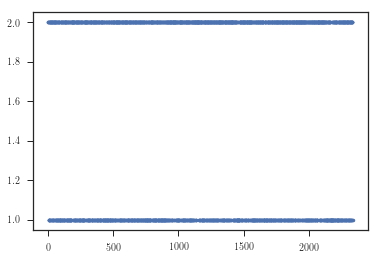

In [226]:
plt.plot(patients[:,1],'.')

In [227]:
#Define a function that calculates the percentage of Ntest patients in each of nclass classes
#Return these probabilities, as well as the prediction for the next observed patient.
def observe(tseries,Ntest,nclass):
    testp = tseries[-Ntest:]
    ratios = []
    for i in range(nclass):
        n = len(testp[testp==(float(i)+1.)])
        ratios.append(float(n)/float(Ntest))
    ratios = np.array(ratios)
    pred = np.random.multinomial(1,ratios)
    pclass = np.where(pred==1)[0]
    return ratios, pclass

In [244]:
#
Ntrail = 50  #Number of trailing patients to use to predict the next diagnosis
i = 0
ypred = []
yobs = []

for obs in patients[Ntrail+1:,1]:
        r, p = observe(patients[Ntrail*i:Ntrail*(i+1),1],Ntrail,2)
        if Ntrail*(i+1)<len(patients):
            ypred.append(p[0]+1.)
            yobs.append(obs)
        else:
            break
        i += 1

yobs = np.array(yobs)
ypred = np.array(ypred)

In [245]:
print confusion_matrix(yobs,ypred)
print classification_report(yobs,ypred)

[[ 3 20]
 [11 12]]
             precision    recall  f1-score   support

        1.0       0.21      0.13      0.16        23
        2.0       0.38      0.52      0.44        23

avg / total       0.29      0.33      0.30        46



In [246]:
print float(len(yobs[yobs==2.]))/float(len(yobs))

0.5


In [247]:
print float(len(ypred[ypred==2.]))/float(len(ypred))

0.695652173913


In [248]:
print precision_score(yobs, ypred)

0.214285714286


In [242]:
#You want something you can plot as a function of time here, so probably you want the precision
#from some windowed set of patients. Say, 10?
window = 100
pwind = []
Ntrail = 50  #Number of trailing patients to use to predict the next diagnosis
i = 0
ypred = []
yobs = []
for obs in patients[Ntrail+1:,1]:
        r, p = observe(patients[i:Ntrail+i,1],30,2)
        if Ntrail+i+1<len(patients):
            ypred.append(p[0]+1.)
            yobs.append(obs)
        else:
            print Ntrail*(i+1), i
            break
        i += 1
        if i%window==0:
            yobs = np.array(yobs)
            ypred = np.array(ypred)
            pscore = precision_score(yobs,ypred)
            pwind.append(pscore)
            ypred = []
            yobs = []


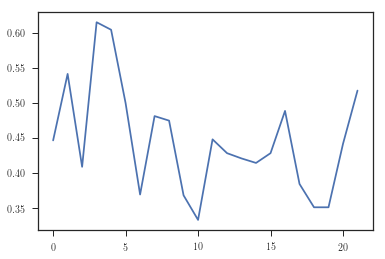

In [243]:
plt.plot(pwind)